# Оценка риска ДТП по выбранному маршруту

**Заказчик исследования:** каршеринговая компания.<br>

**Задача:** создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.<br>

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.<br>

**Идея решения задачи от заказчика:** 
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
1. Возможно ли создать адекватную системe оценки водительского риска при выдаче авто?
2. Какие ещё факторы нужно учесть?
3. Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Загрузка данных

In [1]:
!pip install skorch 

In [2]:
from sqlalchemy import create_engine 
import pandas as pd 
import seaborn as sns 
import numpy as np 
import torch 
import torch.nn as nn 
from math import ceil 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.metrics import SCORERS, roc_auc_score 
from catboost import CatBoostClassifier 
from torch.utils.data import Dataset, DataLoader
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetClassifier  
from skorch.dataset import ValidSplit
pd.options.display.float_format = '{:20,.2f}'.format 

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Обзор данных

### Collisions

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [4]:
query = '''
SELECT *
FROM collisions;
'''

collisions = pd.read_sql_query(query, con=engine) 

In [5]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00,north,0.00,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00,None,1.00,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [6]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

| Обозначение в таблице | Описание | Подробнее |
|---------------------|--------|-------------------|
| CASE_ID |<p>Индификационный номер в базе данных</p>| <p>Уникальный номер для зарегистрированного происшествия в таблице происшествий. </p>|
|COLLISION_DATE|<p>Дата проишествия</p>|<p>Формат год/месяц/день</p>|
|COLLISION_TIME|<p>Время проишествия</p>|<p>Формат:24-часовой</p>|
|INTERSECTION|<p>Является ли место проишествия перекрестком</p>|<p>Y - Intersection (перекресток) <br> N - Not Intersection (не перекресток) <br> -- - Not stated (не указано)</p>|
|WEATHER_1|<p>Погода</p>|<p>A - Clear(Ясно) <br> B - Cloudy(Облачно) <br> C - Rainning(Облачно) <br> D - Snownig(Снегопад) <br> E - Fog(Туман) <br> F - Other (Другое) <br> G - Wind(Ветер) <br> - - Not stated(не указано)</p><br>|
|COLLISON_DAMAGE|<p>Серьёзность проишествия</p>|<p>1 - FATAL TC (не подлежить востановлению)<br>2 - SEVERE DAMAGE (Серьёзный ремонт, большая часть подзамену/Серьёзное повреждение капитального стоения <br> 3 - MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло <br> 4 - SMALL DAMAGE (Отдельный элемент кузова под замену/покраска) <br> 0 -  SCRATCH (царапина)</p>|
|PRIMARY_COLL_FACTOR|<p>Основной фактор аварий</p>|<p> A - Code Violation (Нарушение правил ПДД) <br> B - Other Improper Driving (Другое направильное вождение) <br> C - Other Than Driver (Кроме водителя) <br> D - Unknown (Неизвестно) <br> E - Fell Asleep (Заснул) <br> - - Not Stated (Не указано)</p>|
|ROAD_SURFACE|<p>Состояние дороги</p>|<p>A - Dry (сухая) <br> B - Wet (Мокрая) <br> C - Snowy or Icy (Заснеженная или обледенелая) <br> D - Slippery (Muddy, Oily, ect.)(Скользкая,грязная,маслянистая и т.д.) <br> - - Not Stated(Не указано)</p>|
|LIGHTING|<p>Освещение</p>|<p>A - Daylight(Дневной свет) <br> B - Dusk-Dawn (Сумерки-Рассвет) <br> C - Dark-Street Lights (Темно-Уличные фонари) <br> D - Dark-No Street Lights (Темно-Нет уличных фонарей) <br> E - Dark-Street Lights Not Functioning (Темно-уличные фонари не работают) <br> - - Not State (Не указано)</p>|
|COUNTY_CITY_LOCATION|<p>Номер географических районов, где произошло ДТП</p>|<p>Число</p>|
|COUNTY_LOCATION|<p>Название географических районов, где произошло ДТП</p>|<p>Список разных названий, категориальный тип данных</p>|
|DIRECTION|<p>Направление движения</p>|<p> N - North (Север) <br> E - East (Восток) <br> S - South (Юг) <br> W - West (Запад) - or blank - Not state (не указано) <br> на перекрестке</p>|
|DISTANCE|<p>Растояние от главной дороги (метры)</p>|<p>Число</p>|
|LOCATION_TYPE|<p>Тип дороги</p>|<p> H - Highway(Шоссе) <br> I - Intersection (Перекресток) <br> R - Ramp (or Collector) (Рампа) <br> - or blank - Not State (не указано) </p>|
|PARTY_COUNT|<p>Количестко участников</p>|<p>Число</p>|
|PCF_VIOLATION_CATEGORY|<p>Категория нарушения</p>|<p>01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br>02 — Impeding Traffic (Препятствие движению транспорта)<br>03 — Unsafe Speed (Превышение скорости)<br>04 — Following Too Closely (Опасное сближение)<br>05 — Wrong Side of Road (Неправильная сторона дороги)<br>06 — Improper Passing (Неправильное движение)<br>07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br>08 — Improper Turning (Неправильный поворот)<br>09 — Automobile Right of Way (Автомобильное право проезда)<br>10 — Pedestrian Right of Way (Пешеходное право проезда)<br>11 — Pedestrian Violation (Нарушение пешеходами)<br>12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br>13 — Hazardous Parking (Неправильная парковка)<br>14 — Lights (Освещение)<br>15 — Brakes (Тормоза)<br>16 — Other Equipment (Другое оборудование)<br>17 — Other Hazardous Violation (Другие нарушения)<br>18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br>19 — Speeding (Скорость)<br>20 — Pedestrian dui (Нарушение пешехода)<br>21 — Unsafe Starting or Backing (Опасный старт)<br>22 — Other Improper Driving (Другое неправильное вождение)<br>23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br>24 — Fell Asleep (Заснул)<br>00 — Unknown (Неизвестно)<br>- — Not Stated (Не указано)</p>|
|TYPE_OF_COLLISION|<p>Аварии</p>|<p>A — Head-On (Лоб в лоб)<br>B — Sideswipe (Сторона)<br>C — Rear End (Столкновение задней частью)<br>D — Broadside (Боковой удар)<br>E — Hit Object (Удар объекта)<br>F — Overturned (Опрокинутый)<br>G — Vehicle (транспортное средство/ Пешеход)<br>H — Other (Другое)<br>- — Not Stated (Не указано)</p>|
|MOTOR_VEHICLE_INVOLVED_WITH|<p>Дополнительные участники ДТП</p>|<p>Other motor vehicle (Другой автомобиль)<br>Fixed object (Неподвижный объект)<br>Parked motor vehicle (Припаркованный автомобиль)<br>Pedestrian (Пешеход)<br>Bicycle (Велосипедист)<br>Non-collision (Не столкновение)<br>Other object (Другой объект)<br>Motor vehicle on other roadway (Автомобиль на другой проезжей)<br>Animal (Животное)<br>Train (Поезд)</p>|
|ROAD_CONDITION_1|<p> Дорожное состояние</p>|<p>A — Holes, Deep Ruts (Ямы, глубокая колея)<br>B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br>C — Obstruction on Roadway (Препятствие на проезжей части)<br>D — Construction or Repair Zone (Зона строительства или ремонта)<br>E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br>F — Flooded (Затоплено)<br>G — Other (Другое)<br>H — No Unusual Condition (Нет ничего необычного)<br>- — Not Stated (Не указано)</p>|
|CONTROL_CONDITION_1|<p> Устройство управления</p>|<p>A — Functioning (Функционирует)<br>B — Not Functioning (Не функционирует)<br>C — Obscured (Затемнённый)<br>D — None (Нет)<br>- — Not Stated (Не указано)</p>|

Все данные на месте и соответствуют описанию.<br> 
`control_device` (в таблице) = `control_condition_1` (в описании)

### Parties

Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Если нужен уникальный идентификатор, это `case_id and party_number`.

In [7]:
query = '''
SELECT *
FROM parties;
'''

parties = pd.read_sql_query(query, con=engine) 

In [8]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00,had not been drinking,None,0.00
1,23,3899454,2,road signs,0,7.00,had not been drinking,None,0.00
2,29,3899462,2,car,0,21.00,had not been drinking,None,0.00
3,31,3899465,2,road signs,0,24.00,had not been drinking,None,0.00
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00


In [9]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


|Обозначение в таблице|Описание|Подробнее|
|---------------------|--------|------------------|
|CASE_ID|<p>Идентификационный номер в базе данных</p>|<p>Уникальный номер для зарегестрированного проишествия в таблице проишествий</p>|
|PARTY_NUMBER|<p>Номер участника проишествия</p>|<p> От 1 до N - по числу участников проишествия </p>|
|PARTY_TYPE|<p>Тип участника проишествия</p>|<p>1 — Car (Авто)<br>2 — Road bumper (Дорожные знаки)<br>3 — Building (Строения)<br>4 — Road signs (Отбойник)<br>5 — Other (Другое)<br>6 — Operator (Оператор)<br>- — Not Stated (Не указано)</p>|
|AT_FAULT|<p>Виновность участника</p>|<p>0/1</p>|
|INSURANCE_PREMIUM|<p>Сумма страховки (тыс.$) </p>|<p>Число</p>|
|PARTY_DRUG_PHYSICAL|<p>Состояние участника: физическое или с учетом принятых лекарств</p>|<p>E — Under Drug Influence (Под воздействием лекарств)<br>F — Impairment — Physical (Ухудшение состояния)<br>G — Impairment Unknown (Не известно)<br>H — Not Applicable (Не оценивался)<br>I — Sleepy/Fatigued (Сонный/Усталый)<br>- — Not Stated (Не указано)</p>|
|PARTY_SOBRIETY|<p>Трезвость участника</p>|<p>A — Had Not Been Drinking (Не пил)<br>B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br>C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br>D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br>G — Impairment Unknown (Неизвестно ухудшение)<br>H — Not Applicable (Не оценивался)<br>- — Not Stated (Не указано)</p>|
|CELLPHONE_IN_USE|<p>Наличие телефона в автомобиле (возможность||

Все данные на месте и соответсвуют описанию.

### Vehicles

Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id and party_number`.

In [10]:
query = '''
SELECT *
FROM vehicles;
'''

vehicles = pd.read_sql_query(query, con=engine) 

In [11]:
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.00
1,1,3858022,1,sedan,auto,3.00
2,1175712,5305030,1,sedan,auto,3.00
3,1175717,5305033,3,sedan,auto,5.00
4,1175722,5305034,2,sedan,auto,5.00


In [12]:
vehicles.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


|Обозначение в таблице|<p>Описание</p>|<p>Подробнее</p>|
|---------------------|--------|-------------------|
|ID|<p>Индекс текущей таблицы</p>|<p>Номекр в таблице</p>|
|CASE_ID|<p>Идентификационный номер в базу данных</p>|<p>Уникальный номер для зарегестрированного проишествия в таблице проишествий</p>|
|VEHICLE_TYPE|<p>Тип кузова</p>|<p>MINIVAN<br>COUPE<br>SEDAN<br>HATCHBACK<br>OTHER</p>|
|VEHICLE_TRANSMISSION|<p>Тип КПП</p>|<p>auto (Автоматическая)<br>manual (Ручная)<br>- — Not Stated (Не указано)</p>|
|VEHICLE_AGE|<p>Возраст автомобиля (в годаз)</p>|<p> число</p>|

Все данные на месте и соответствуют описанию.

### Вывод

У нас есть 3 таблицы, как и должно быть по условию. Для каждой таблицы имеется описание столбцов. Данных достаточно для исследования.<br>

Все таблицы связаны друг с другом общим ключом `case_id` - идентификатором происшествия. А также таблицы `parties` и `vehicles` связаны ключом `party_number` - номером участника происшествия.<br>

По сути получается, что в таблице `parties` содержится информация обо всех участниках ДТП: людях, автомобилях и сторонних предметах. А таблица `vehicles` расширяет информацию только обо автомобилях.<br>

Таблица `parties` - 2,7 млн. записей<br>
Таблица `collisions` - 1,4 млн. записей<br>
Таблица `vehicles` - 1 млн. записей

## Статистический анализ факторов ДТП

### Месяцы с наибольшим количеством аварий

Для начала проверим, за какой период есть данные в таблице вообще.

In [13]:
query = '''
SELECT DATE_TRUNC('month', collision_date)::date,
    COUNT(*)
FROM collisions
GROUP BY DATE_TRUNC('month', collision_date)::date;
'''

pd.read_sql_query(query, con=engine) 

,date_trunc,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


Данные за весь год есть только за период 2009-2012, несколько записей за 2013 и 2020 (их можно вообще не учитывать, на статистику не повлияют). С июня 2012 резко сократилось число ДТП - это может быть связано либо с каким-то нововведением, которое могло способствовать уменьшению аварий, либо с неполнотой данных.

Теперь подсчитаем статистику с количеством аварий по месяцам суммарно. Данные за 2013 и 2020 лучше не использовать, чтобы не создавали перевес.

In [14]:
query = '''
SELECT EXTRACT(MONTH FROM collision_date)::int,
    COUNT(*)
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) BETWEEN 2009 AND 2012
GROUP BY EXTRACT(MONTH FROM collision_date)
ORDER BY COUNT(*) DESC;
'''

collisions_per_month = pd.read_sql_query(query, con=engine) 

In [15]:
collisions_per_month

,date_part,count
0,3,139534
1,1,131900
2,5,130316
3,4,130175
4,2,128750
5,10,112237
6,12,107945
7,9,105159
8,11,104770
9,8,104089


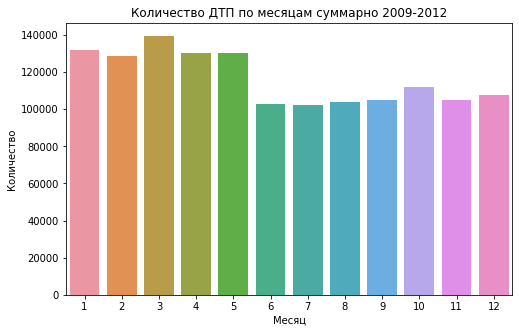

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(x=collisions_per_month['date_part'], y=collisions_per_month['count'])
plt.title('Количество ДТП по месяцам суммарно 2009-2012')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

А теперь вычислим средние значения по каждому месяцу.

In [17]:
query = '''
WITH t AS (SELECT DATE_TRUNC('month', collision_date)::date AS date_month,
                COUNT(*) AS cnt
           FROM collisions
           GROUP BY DATE_TRUNC('month', collision_date)::date)
           
SELECT EXTRACT(MONTH FROM date_month)::int AS month,
    AVG(cnt)::int
FROM t
WHERE EXTRACT(YEAR FROM date_month) BETWEEN 2009 AND 2012
GROUP BY EXTRACT(MONTH FROM date_month)
ORDER BY avg DESC;
'''

collisions_per_month = pd.read_sql_query(query, con=engine) 

In [18]:
collisions_per_month

,month,avg
0,3,34884
1,1,32975
2,5,32579
3,4,32544
4,2,32188
5,10,28059
6,12,26986
7,9,26290
8,11,26193
9,8,26022


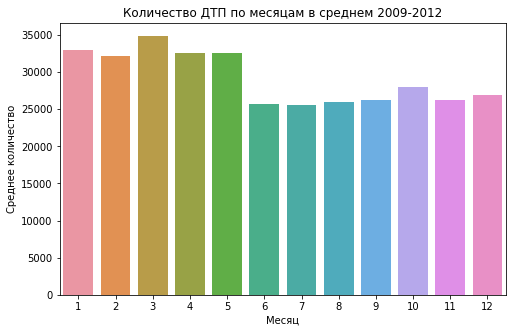

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(x=collisions_per_month['month'], y=collisions_per_month['avg'])
plt.title('Количество ДТП по месяцам в среднем 2009-2012')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество')
plt.show()

#### Вывод

Оба графика показывают одинаковую тенденцию - в марте обычно случается больше аварий, чем в другие месяцы. Это может быть связано с нестабильной погодой в марте: если днём была плюсовая температура, а ночью минусовая, то на дорогах будет гололёд.

### Задачи для коллег

1) Выясните причину резкого сокращения количества ДТП с июня 2012. Было ли какое-то нововведение в то время, которое привело к сокращению случаев? Сколько машин было в автопарке до и после события? Поищите другие базы данных, где может ещё храниться информация за этот период, а также за период 2013-2020, если такие есть.<br>

2) Проведите анализ количества аварий в зависимости от города происшествия.<br>

3) Проанализируйте зависимость тяжести повреждения от того, находился ли виновник под влиянием лекарств или алкогольного опьенения:<br>

- Создайте sql-запрос;
- Постройте график;
- Сделайте вывод.<br>

4) Соберите статистику по частоте аварий в зависимости от возраста автомобиля.<br>

5) Выясните, в какое время суток чаще случаются ДТП из-за нетрезвости водителя:<br>

- Создайте sql-запрос;
- Постройте график;
- Сделайте вывод.<br>

6) Посчитайте статистику типов ДТП.

## Модель для оценки водительского риска

In [20]:
# подготовка исходной таблицы, первичный отбор факторов
query = '''
SELECT c.case_id,
       p.party_number,
       at_fault,
       insurance_premium,
       party_sobriety,
       party_drug_physical,
       cellphone_in_use,
       county_city_location,
       county_location,
       distance,
       direction,
       intersection,
       weather_1,
       location_type,
       collision_damage,
       party_count,
       primary_collision_factor,
       pcf_violation_category,
       type_of_collision,
       motor_vehicle_involved_with,
       road_surface,
       road_condition_1,
       lighting,
       control_device,
       collision_date,
       collision_time,
       vehicle_type,
       vehicle_transmission,
       vehicle_age
FROM parties AS p
JOIN collisions AS c ON p.case_id=c.case_id
JOIN vehicles AS v ON c.case_id=v.case_id
WHERE party_type = 'car'
    AND collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM collision_date) = 2012;
'''

df = pd.read_sql_query(query, con=engine) 

In [21]:
df.head()

,case_id,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,county_location,distance,...,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5403037,1,1,19.00,"had been drinking, under influence",under drug influence,0.00,3500,san benito,0.00,...,fixed object,dry,loose material,dark with street lights,functioning,2012-01-13,02:55:00,sedan,manual,3.00
1,5454272,1,1,19.00,had not been drinking,None,0.00,3010,orange,36.00,...,other motor vehicle,wet,normal,daylight,functioning,2012-01-23,11:07:00,sedan,manual,0.00
2,5454272,2,0,26.00,had not been drinking,None,0.00,3010,orange,36.00,...,other motor vehicle,wet,normal,daylight,functioning,2012-01-23,11:07:00,sedan,manual,0.00
3,5455652,2,0,33.00,had not been drinking,None,0.00,4806,solano,0.00,...,other object,dry,normal,dark with street lights,functioning,2012-01-01,17:53:00,hatchback,manual,11.00
4,5456212,1,1,51.00,had not been drinking,None,1.00,3400,sacramento,300.00,...,other motor vehicle,dry,normal,daylight,none,2012-01-13,15:40:00,sedan,manual,3.00


In [22]:
df.columns 

Index(['case_id', 'party_number', 'at_fault', 'insurance_premium',
       'party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'county_city_location', 'county_location', 'distance', 'direction',
       'intersection', 'weather_1', 'location_type', 'collision_damage',
       'party_count', 'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'collision_date',
       'collision_time', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age'],
      dtype='object')

Отберём только те факторы, которые с наибольшей вероятностью влияют на аварийность. Т.о., от некоторых факторов можно избавиться:
- `insurance_premium` - сумма страховки в данном случае не нужна, т.к. относится к последствиям аварии, а не факторам риска
- `cellphone_in_use`
- `county_city_location` - дублирует колонку `county_location`
- `intersection` - возможно, придётся удалить, т.к. есть ещё колонка `location_type`, в которой дублируется информация о перекрёстке. Но пока оставим для дальнейшего изучения
- `primary_collision_factor` - дублирует колонку `pcf_violation_category`, но в `pcf_violation_category` даётся больше информации, поэтому лучше оставить её
- `control_device` - вряд ли устройство слежения может предотвратить аварию

In [23]:
df = df.drop(columns=[
        'insurance_premium',
        'cellphone_in_use',
        'county_city_location',
        'primary_collision_factor',
        'control_device'
        ])

In [24]:
df.head()

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,direction,intersection,weather_1,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5403037,1,1,"had been drinking, under influence",under drug influence,san benito,0.00,None,1.00,clear,...,hit object,fixed object,dry,loose material,dark with street lights,2012-01-13,02:55:00,sedan,manual,3.00
1,5454272,1,1,had not been drinking,None,orange,36.00,north,0.00,raining,...,rear end,other motor vehicle,wet,normal,daylight,2012-01-23,11:07:00,sedan,manual,0.00
2,5454272,2,0,had not been drinking,None,orange,36.00,north,0.00,raining,...,rear end,other motor vehicle,wet,normal,daylight,2012-01-23,11:07:00,sedan,manual,0.00
3,5455652,2,0,had not been drinking,None,solano,0.00,None,1.00,clear,...,other,other object,dry,normal,dark with street lights,2012-01-01,17:53:00,hatchback,manual,11.00
4,5456212,1,1,had not been drinking,None,sacramento,300.00,south,0.00,clear,...,rear end,other motor vehicle,dry,normal,daylight,2012-01-13,15:40:00,sedan,manual,3.00


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      118411 non-null  object 
 1   party_number                 118411 non-null  int64  
 2   at_fault                     118411 non-null  int64  
 3   party_sobriety               116682 non-null  object 
 4   party_drug_physical          8695 non-null    object 
 5   county_location              118411 non-null  object 
 6   distance                     118411 non-null  float64
 7   direction                    89466 non-null   object 
 8   intersection                 118043 non-null  float64
 9   weather_1                    118022 non-null  object 
 10  location_type                55137 non-null   object 
 11  collision_damage             118411 non-null  object 
 12  party_count                  118411 non-null  int64  
 13 

### Числовые признаки

- `distance`
- `party_count`
- `vehicle_age`

In [26]:
def num_info(column):
    
    print(column, '\n')
    print(df[column].describe())
    print('\nКоличество пропусков:', df[column].isna().sum())
    print('\nДоля пропусков:', df[column].isna().sum()/len(df[column])) 

In [27]:
def visualize_num(column):
    
    fig, ax = plt.subplots(2,1, figsize=(10,10)) 
    fig.suptitle(column)
    
    ax[0].hist(df[column]) 
    ax[0].set_title('График распределения значений')
    
    ax[1].boxplot(df[column], vert=False)
    ax[1].set_title('График размаха значений')
    
    plt.show() 

#### distance

 - расстояние от главной дороги в метрах

In [28]:
num_info('distance')

distance 

count             118,411.00
mean                  732.07
std                 6,902.70
min                     0.00
25%                     2.00
50%                   118.00
75%                   528.00
max             1,584,000.00
Name: distance, dtype: float64

Количество пропусков: 0

Доля пропусков: 0.0


Здесь налицо наличие больших выбросов.

Найдём границу, в которую входят 99% значений, посчитаем долю выбросов и удалим их.

In [29]:
df['distance'].quantile(.99) 

9504.0

In [30]:
df[df['distance'] > df['distance'].quantile(.99)]['distance'].count()/len(df['distance']) 

0.009593703287701311

In [31]:
df = df[df['distance'] <= df['distance'].quantile(.99)] 

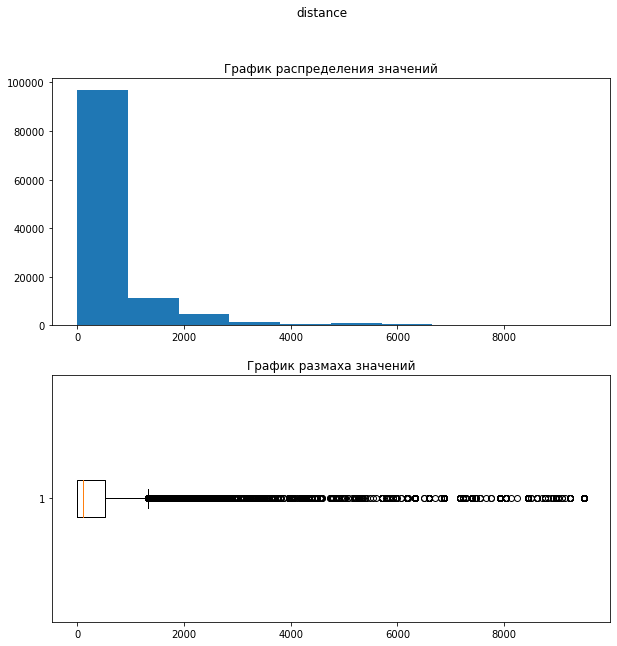

In [32]:
visualize_num('distance')

В колонке всё ещё остались выбросы, сначала попробуем оставить так и обучить модель. Потом вернёмся к экспериментам с выбросами.

#### party_count

- количество участников ДТП

In [33]:
num_info('party_count')

party_count 

count             117,275.00
mean                    2.36
std                     0.95
min                     1.00
25%                     2.00
50%                     2.00
75%                     3.00
max                    10.00
Name: party_count, dtype: float64

Количество пропусков: 0

Доля пропусков: 0.0


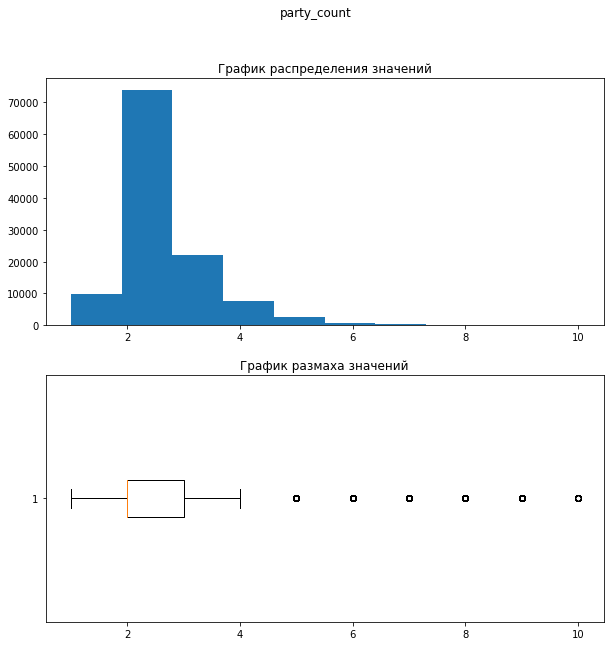

In [34]:
visualize_num('party_count')

Большинство аварий имеют двух участников. Выбросы есть, но, в целом, распределение значений выглядит вполне адекватным.

Интересно посмотреть на аварии, где только один участник.

In [35]:
df.query('party_count == 1').head(10)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,direction,intersection,weather_1,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5403037,1,1,"had been drinking, under influence",under drug influence,san benito,0.00,None,1.00,clear,...,hit object,fixed object,dry,loose material,dark with street lights,2012-01-13,02:55:00,sedan,manual,3.00
15,5507756,1,1,had not been drinking,None,orange,35.00,east,0.00,clear,...,None,other motor vehicle,dry,normal,daylight,2012-02-02,16:15:00,sedan,auto,0.00
23,5514472,1,1,had not been drinking,None,marin,"3,168.00",west,0.00,clear,...,hit object,fixed object,dry,normal,dark with no street lights,2012-01-14,21:30:00,sedan,auto,3.00
33,5536151,1,1,had not been drinking,None,san diego,150.00,east,0.00,cloudy,...,overturned,non-collision,dry,normal,dark with street lights,2012-02-12,20:52:00,coupe,manual,3.00
43,5576053,1,1,"had been drinking, under influence",None,kern,50.00,south,0.00,clear,...,hit object,fixed object,dry,normal,dark with street lights,2012-04-04,00:02:00,sedan,auto,3.00
49,5585866,1,1,None,sleepy/fatigued,contra costa,781.00,north,0.00,clear,...,hit object,fixed object,dry,normal,daylight,2012-04-24,08:51:00,coupe,auto,5.00
51,5588046,1,0,had not been drinking,None,sacramento,20.00,south,0.00,clear,...,other,animal,dry,normal,daylight,2012-04-07,12:22:00,coupe,manual,12.00
57,5609803,1,1,had not been drinking,None,calaveras,"1,000.00",south,0.00,clear,...,hit object,fixed object,dry,normal,daylight,2012-05-07,10:31:00,coupe,auto,10.00
64,5456769,1,1,"had been drinking, under influence",None,santa clara,627.00,north,0.00,clear,...,broadside,fixed object,dry,normal,dark with no street lights,2012-01-12,23:10:00,coupe,manual,6.00
65,5456851,1,1,had not been drinking,None,orange,68.00,south,0.00,cloudy,...,hit object,fixed object,dry,normal,daylight,2012-01-11,10:03:00,coupe,manual,4.00


К таким записям относятся столкновения с недвижимым объектом или опрокидывание автомобиля.

#### vehicle_age

In [36]:
num_info('vehicle_age')

vehicle_age 

count             113,917.00
mean                    4.90
std                     3.27
min                     0.00
25%                     3.00
50%                     4.00
75%                     7.00
max                   161.00
Name: vehicle_age, dtype: float64

Количество пропусков: 3358

Доля пропусков: 0.028633553613302068


Сначала изучим пропуски.

In [37]:
df[df['vehicle_age'].isna()].head(10)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,direction,intersection,weather_1,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
72,5457107,1,1,impairment unknown,G,los angeles,150.00,north,0.00,clear,...,rear end,other motor vehicle,dry,normal,daylight,2012-01-29,07:20:00,sedan,auto,NaN
73,5457107,2,0,had not been drinking,None,los angeles,150.00,north,0.00,clear,...,rear end,other motor vehicle,dry,normal,daylight,2012-01-29,07:20:00,sedan,auto,NaN
77,5457330,1,1,had not been drinking,None,los angeles,0.00,None,1.00,clear,...,broadside,bicycle,dry,normal,daylight,2012-01-13,15:05:00,sedan,auto,NaN
194,5460713,1,1,had not been drinking,None,orange,0.00,None,1.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-01-15,12:34:00,sedan,None,NaN
196,5460713,2,0,had not been drinking,None,orange,0.00,None,1.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-01-15,12:34:00,sedan,None,NaN
251,5465055,1,1,impairment unknown,G,butte,24.00,west,0.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-01-14,16:00:00,sedan,auto,NaN
252,5465055,2,0,had not been drinking,None,butte,24.00,west,0.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-01-14,16:00:00,sedan,auto,NaN
265,5466959,1,1,impairment unknown,G,riverside,500.00,east,0.00,clear,...,sideswipe,other motor vehicle,dry,normal,daylight,2012-01-19,10:00:00,sedan,auto,NaN
266,5466959,2,0,had not been drinking,None,riverside,500.00,east,0.00,clear,...,sideswipe,other motor vehicle,dry,normal,daylight,2012-01-19,10:00:00,sedan,auto,NaN
339,5475626,1,1,"had been drinking, impairment unknown",None,los angeles,0.00,None,1.00,clear,...,hit object,fixed object,dry,normal,dark with street lights,2012-01-11,22:45:00,sedan,auto,NaN


Эти данные могут быть полезными, пропуски можно заменить медианным значением.

In [38]:
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median()) 

Теперь посмотрим на выбросные данные.

In [39]:
df.query('vehicle_age > 20')

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,direction,intersection,weather_1,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
78595,5639033,1,1,had not been drinking,None,los angeles,0.00,None,1.00,clear,...,head-on,other motor vehicle,dry,normal,dusk or dawn,2012-12-05,05:55:00,sedan,manual,161.00
78597,5639033,2,0,had not been drinking,None,los angeles,0.00,None,1.00,clear,...,head-on,other motor vehicle,dry,normal,dusk or dawn,2012-12-05,05:55:00,sedan,manual,161.00
96046,5542342,1,1,had not been drinking,None,los angeles,449.00,north,0.00,clear,...,head-on,other motor vehicle,dry,normal,daylight,2012-06-20,11:45:00,sedan,manual,161.00
96048,5542342,2,0,had not been drinking,None,los angeles,449.00,north,0.00,clear,...,head-on,other motor vehicle,dry,normal,daylight,2012-06-20,11:45:00,sedan,manual,161.00


Значение возраста 161 да ещё и одинаковое для нескольких записей не внушает доверия - т.к. таких записей всего 4, можно безболезненно удалить сомнительные данные.

In [40]:
df = df.query('vehicle_age < 161')

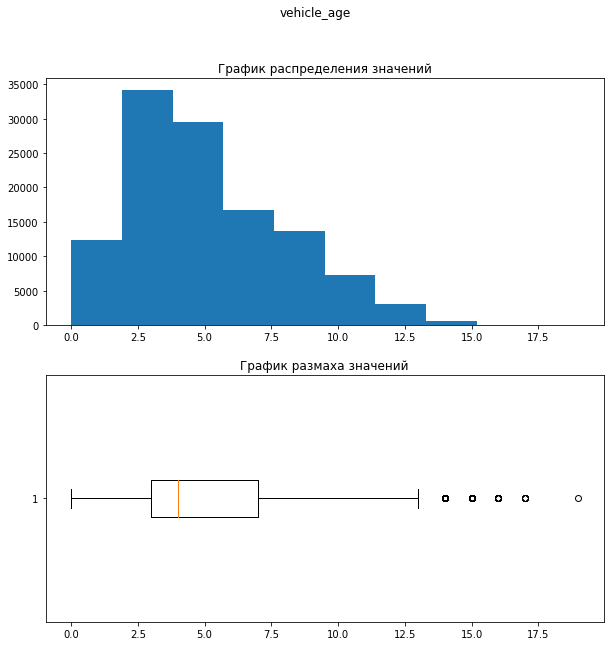

In [41]:
visualize_num('vehicle_age')

Автомобили возрастом больше 13 лет встречаются очень редко, но такое теоретически может быть, поэтому оставим данные на месте. В основном, автомобили возрастом 2-5 лет.

### Категориальные признаки

- `party_sobriety`
- `party_drug_physical`
- `county_location`
- `direction`
- `intersection`
- `weather_1`
- `location_type`
- `collision_damage`
- `pcf_violation_category`
- `type_of_collision`
- `motor_vehicle_involved_with`
- `road_surface`
- `road_condition_1`
- `lighting`
- `collision_date`
- `collision_time`
- `vehicle_type`
- `vehicle_transmission`

In [42]:
def cat_info(column):
    print('Количество пропусков:', df[column].isna().sum())
    print('\nДоля пропусков:', df[column].isna().sum()/len(df[column]), '\n')  
    print(df[column].value_counts())

In [43]:
def visualize_cat(column, figsize=(8,5)):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y=df[column].value_counts().index, width=df[column].value_counts().values)
    ax.set_title(f'Статистика по {column}')
    plt.show() 

#### party_sobriety

- трезвость участника

In [44]:
df['party_sobriety'].unique() 

array(['had been drinking, under influence', 'had not been drinking',
       'impairment unknown', None,
       'had been drinking, not under influence',
       'had been drinking, impairment unknown', 'not applicable'],
      dtype=object)

Для начала интересно посмотреть на значения `impairment unknown`.

Логично будет объединить все категории `had been drinking` в одну.

In [45]:
df['party_sobriety'] = df['party_sobriety'].replace({'had been drinking, under influence': 'had been drinking',
                                                    'had been drinking, impairment unknown': 'had been drinking',
                                                    'had been drinking, not under influence': 'had been drinking'})

In [46]:
cat_info('party_sobriety')

Количество пропусков: 1712

Доля пропусков: 0.014598664631494573 

had not been drinking    100986
had been drinking          7935
impairment unknown         6058
not applicable              580
Name: party_sobriety, dtype: int64


Далее изучим пропуски.

In [47]:
df[df['party_sobriety'].isna()].sample(10)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,direction,intersection,weather_1,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
74587,5486976,1,1,None,under drug influence,placer,175.00,north,0.00,clear,...,hit object,fixed object,dry,normal,dark with street lights,2012-01-15,01:54:00,coupe,None,5.00
58413,5638286,1,1,None,under drug influence,merced,"3,168.00",west,0.00,clear,...,sideswipe,other motor vehicle,dry,normal,daylight,2012-07-22,12:16:00,sedan,auto,9.00
80966,5529944,2,0,None,None,santa clara,100.00,west,0.00,clear,...,other,other object,dry,normal,daylight,2012-03-06,15:07:00,hatchback,None,1.00
54541,5480531,1,0,None,impairment - physical,ventura,528.00,east,0.00,cloudy,...,hit object,fixed object,dry,normal,daylight,2012-01-15,15:25:00,sedan,auto,6.00
49165,5625586,1,1,None,None,sacramento,0.00,None,1.00,clear,...,sideswipe,other motor vehicle,dry,normal,daylight,2012-05-12,10:44:00,coupe,auto,8.00
12019,5564168,5,0,None,None,los angeles,0.00,None,1.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-02-25,13:20:00,coupe,manual,3.00
63698,5645521,3,0,None,None,riverside,0.00,None,1.00,clear,...,rear end,other motor vehicle,dry,normal,daylight,2012-05-05,11:05:00,sedan,auto,7.00
16326,5537421,2,0,None,None,los angeles,685.00,east,0.00,clear,...,broadside,other motor vehicle,dry,normal,dark with street lights,2012-02-22,18:10:00,sedan,manual,7.00
80314,5506793,1,1,None,sleepy/fatigued,yuba,256.00,north,0.00,clear,...,hit object,fixed object,dry,normal,daylight,2012-02-12,13:55:00,coupe,auto,4.00
32886,5622245,1,1,None,under drug influence,shasta,66.00,east,0.00,clear,...,broadside,other motor vehicle,dry,normal,daylight,2012-02-13,14:01:00,sedan,auto,7.00


Здесь пропуски можно заменить значением `impairment unknown`.

In [48]:
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown') 

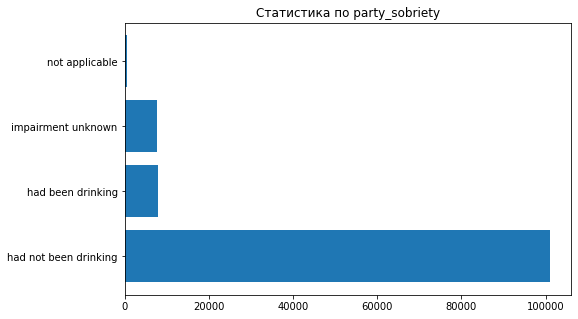

In [49]:
visualize_cat('party_sobriety')

Большинство водителей всё же ездят трезвыми.

#### party_drug_physical

- Состояние участника: физическое или с учетом принятых лекарств

In [50]:
df['party_drug_physical'].unique()

array(['under drug influence', None, 'G', 'sleepy/fatigued',
       'impairment - physical', 'not applicable'], dtype=object)

In [51]:
cat_info('party_drug_physical')

Количество пропусков: 108675

Доля пропусков: 0.9266996955769116 

G                        6058
under drug influence     1277
not applicable            580
sleepy/fatigued           506
impairment - physical     175
Name: party_drug_physical, dtype: int64


Пропуски в этой колонке могут означать, что участник не был в угнетённом физическом состоянии. Можно свести колонку к трём категориям: `under influence`, `not under inflience`, `not applicable`.

In [52]:
df['party_drug_physical'] = df['party_drug_physical'].replace({'G': 'under influence',
                                                              'under drug influence': 'under influence',
                                                              'sleepy/fatigued': 'under influence',
                                                              'impairment - physical': 'under influence'}) 

df['party_drug_physical'] = df['party_drug_physical'].fillna('not under inflience') 

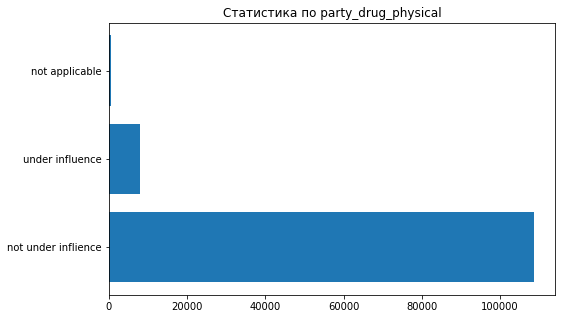

In [53]:
visualize_cat('party_drug_physical')

Большинство водителей на момент аварии не находились в угнетённом состоянии.

#### county_location

In [54]:
df['county_location'].unique() 

array(['san benito', 'orange', 'solano', 'sacramento', 'los angeles',
       'contra costa', 'stanislaus', 'alameda', 'riverside',
       'san joaquin', 'el dorado', 'nevada', 'marin', 'yuba', 'san diego',
       'san bernardino', 'santa clara', 'kern', 'ventura', 'placer',
       'san mateo', 'calaveras', 'yolo', 'tulare', 'fresno',
       'san francisco', 'humboldt', 'santa barbara', 'butte', 'sutter',
       'san luis obispo', 'shasta', 'lake', 'tehama', 'napa', 'merced',
       'monterey', 'glenn', 'mono', 'sonoma', 'mendocino', 'santa cruz',
       'tuolumne', 'amador', 'madera', 'kings', 'lassen', 'imperial',
       'siskiyou', 'inyo', 'mariposa', 'sierra', 'del norte', 'trinity',
       'plumas', 'colusa', 'modoc', 'alpine'], dtype=object)

In [55]:
cat_info('county_location')

Количество пропусков: 0

Доля пропусков: 0.0 

los angeles        36310
orange             11905
san diego           7593
san bernardino      7211
riverside           6831
sacramento          4747
santa clara         4123
alameda             3974
ventura             2980
kern                2647
contra costa        2113
san mateo           2101
fresno              1960
san joaquin         1862
stanislaus          1616
santa barbara       1443
tulare              1371
sonoma              1365
placer              1184
san francisco       1143
monterey            1127
solano              1110
santa cruz           889
san luis obispo      773
marin                765
merced               747
madera               619
yolo                 577
butte                574
humboldt             564
el dorado            489
kings                476
shasta               459
napa                 380
imperial             355
nevada               287
sutter               281
mendocino            273
teh

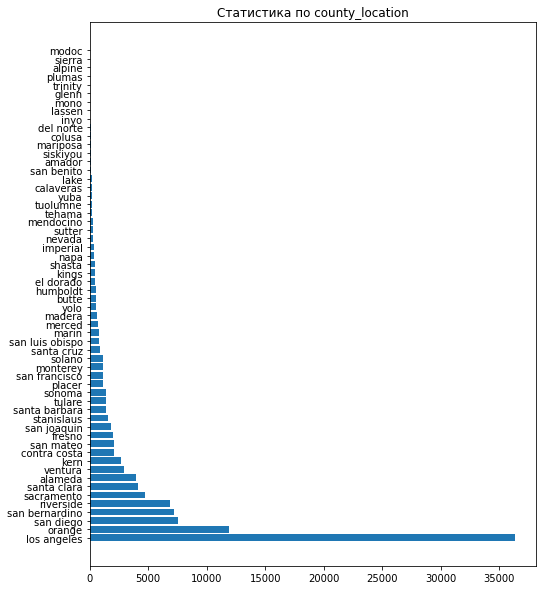

In [56]:
visualize_cat('county_location', figsize=(8,10))

Видно, что в Лос-Анджелесе значительно чаще случаются аварии. Наверное, там и автопарк больше, чем в других городах.

#### direction

In [57]:
df['direction'].unique()

array([None, 'north', 'south', 'west', 'east'], dtype=object)

In [58]:
cat_info('direction')

Количество пропусков: 28942

Доля пропусков: 0.2467958830401378 

north    24806
south    24448
west     19878
east     19197
Name: direction, dtype: int64


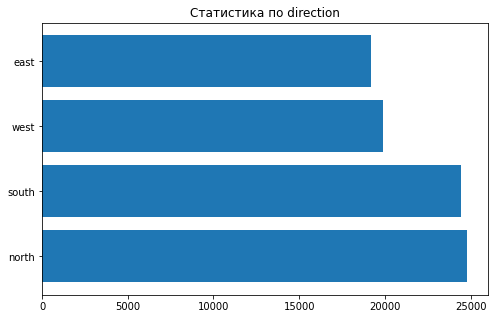

In [59]:
visualize_cat('direction')

В этой колонке слишком много пропусков, подобрать значение на замену для них не получится. Как видно на графике, значения распределены примерно равномерно, а значит, направление движения почти не влияет на факт возникновения аварии. В связи с этими факторами, целесообразно эту колонку удалить.

In [60]:
df = df.drop('direction', axis=1) 

#### weather

In [61]:
# сразу переименуем колонку для удобства
df = df.rename(columns={'weather_1': 'weather'})

In [62]:
df['weather'].unique()

array(['clear', 'raining', 'cloudy', 'fog', None, 'snowing', 'other',
       'wind'], dtype=object)

In [63]:
cat_info('weather')

Количество пропусков: 389

Доля пропусков: 0.0033171031201234746 

clear      95157
cloudy     16838
raining     4177
fog          383
snowing      246
other         58
wind          23
Name: weather, dtype: int64


Пропусков тут немного, пусть будет `other`.

In [64]:
df['weather'] = df['weather'].fillna('other')

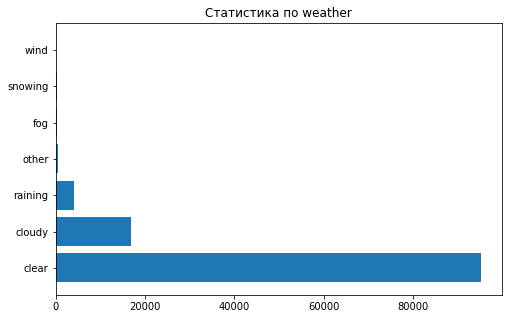

In [65]:
visualize_cat('weather')

В большинстве случаев погода не влияет на факт возникновения аварии.

#### location_type и intersection

In [66]:
df['location_type'].unique()

array([None, 'highway', 'ramp', 'intersection'], dtype=object)

In [67]:
cat_info('location_type')

Количество пропусков: 62957

Доля пропусков: 0.5368505427599322 

highway         45195
ramp             6253
intersection     2866
Name: location_type, dtype: int64


In [68]:
df['intersection'].unique()

array([ 1.,  0., nan])

In [69]:
cat_info('intersection')

Количество пропусков: 367

Доля пропусков: 0.003129503457802867 

0.00    89200
1.00    27704
Name: intersection, dtype: int64


Пропусков в колонке `intersection` намного меньше, чем в `location_type`, а значит, с ней будет удобнее работать. Можем попробовать восстановить пропуски `intersection` с помощью колонки `location_type`.

In [70]:
df[df['intersection'].isna()].sample(5)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,intersection,weather,location_type,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
9470,5456331,1,1,had been drinking,not under inflience,contra costa,295.00,NaN,raining,None,...,rear end,other motor vehicle,wet,normal,dark with street lights,2012-01-20,21:14:00,sedan,manual,2.00
106169,5579454,1,1,impairment unknown,under influence,san mateo,0.00,NaN,raining,None,...,hit object,fixed object,wet,normal,dark with no street lights,2012-03-25,02:00:00,sedan,auto,9.00
106168,5579454,1,1,impairment unknown,under influence,san mateo,0.00,NaN,raining,None,...,hit object,fixed object,wet,normal,dark with no street lights,2012-03-25,02:00:00,sedan,manual,7.00
81865,5560761,2,0,had not been drinking,not under inflience,orange,150.00,NaN,clear,highway,...,rear end,other motor vehicle,dry,normal,daylight,2012-03-23,16:45:00,sedan,auto,2.00
29250,5667150,1,1,impairment unknown,under influence,los angeles,0.00,NaN,clear,None,...,rear end,fixed object,dry,normal,daylight,2012-05-30,11:50:00,sedan,auto,5.00


In [71]:
def fill_intersection(row):
    if row['location_type'] == 'intersection':
        row['intersection'] = 1
    elif row['location_type'] == 'highway' or row['location_type'] == 'ramp':
        row['intersection'] = 0
    return row  

In [72]:
df = df.apply(fill_intersection, axis=1) 

In [73]:
df['intersection'].isna().sum() 

302

Немного удалось сократить количество пропусков.

In [74]:
# переименуем категории
df['intersection'] = df['intersection'].apply(lambda x: 'not intersection' if x == 0 else ('intersection' if x == 1 else 'unknown'))

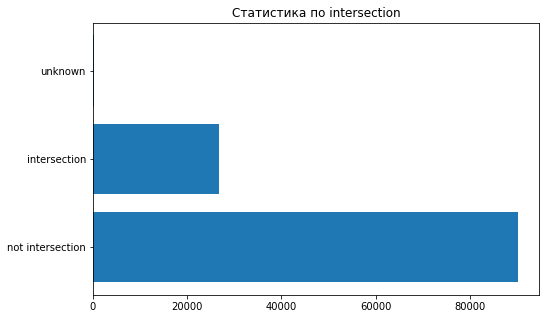

In [75]:
visualize_cat('intersection')

Большинство аварий происходит не на перекрёстках.

Т.к. мы в итоге решили использовать колонку `intersection`, `location_type` можно удалить.

In [76]:
df = df.drop('location_type', axis=1) 

#### collision_damage

In [77]:
df['collision_damage'].unique()

array(['fatal', 'small damage', 'middle damage', 'severe damage'],
      dtype=object)

In [78]:
cat_info('collision_damage')

Количество пропусков: 0

Доля пропусков: 0.0 

small damage     62445
middle damage    41499
severe damage     7482
fatal             5845
Name: collision_damage, dtype: int64


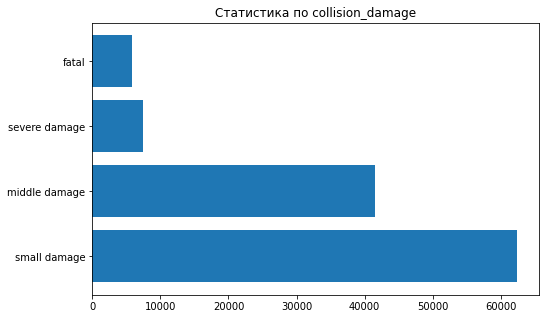

In [79]:
visualize_cat('collision_damage')

Радует, что в большинстве случаев исход аварии ограничивается небольшим повреждением.

#### pcf_violation_category

In [80]:
df['pcf_violation_category'].unique()

array(['dui', 'speeding', 'pedestrian violation', 'improper turning',
       'automobile right of way', 'unsafe lane change',
       'unsafe starting or backing', 'traffic signals and signs',
       'wrong side of road', 'other than driver (or pedestrian)',
       'following too closely', None, 'unknown',
       'pedestrian right of way', 'improper passing', 'brakes',
       'other equipment', 'other improper driving',
       'other hazardous violation', 'lights', 'impeding traffic',
       'hazardous parking', 'fell asleep'], dtype=object)

In [81]:
cat_info('pcf_violation_category')

Количество пропусков: 1720

Доля пропусков: 0.014666882690520248 

speeding                             41374
automobile right of way              15421
improper turning                     12852
dui                                  10378
unsafe lane change                   10237
traffic signals and signs             7733
wrong side of road                    3167
unsafe starting or backing            2762
following too closely                 2392
unknown                               1974
pedestrian violation                  1704
other than driver (or pedestrian)     1635
other hazardous violation             1172
improper passing                      1010
pedestrian right of way                988
other improper driving                 432
other equipment                        151
impeding traffic                        80
hazardous parking                       50
brakes                                  20
lights                                  16
fell asleep                   

Заменим пропуски на `unknown`.

In [82]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown') 

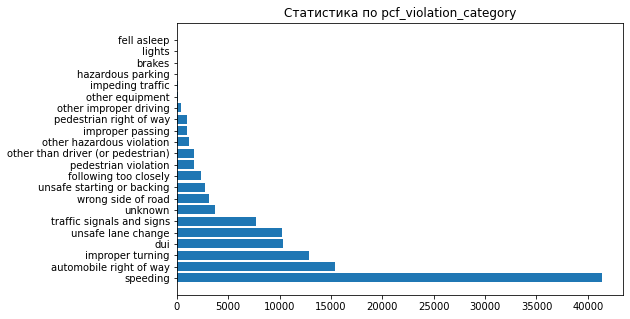

In [83]:
visualize_cat('pcf_violation_category')

В основном, аварии случаются из-за нарушений скоростного режима, правил приоритета проезда и правил совершения поворота. Однако, хорошо, что водители не спят за рулём.

#### type_of_collision

In [84]:
df['type_of_collision'].unique()

array(['hit object', 'rear end', 'other', 'broadside', 'overturned', None,
       'sideswipe', 'head-on'], dtype=object)

In [85]:
cat_info('type_of_collision')

Количество пропусков: 640

Доля пропусков: 0.0054574447220540456 

rear end      45219
broadside     26312
sideswipe     19816
hit object     9845
head-on        6833
other          6082
overturned     2524
Name: type_of_collision, dtype: int64


Пропусков немного - заменим на `other`.

In [86]:
df['type_of_collision'] = df['type_of_collision'].fillna('other') 

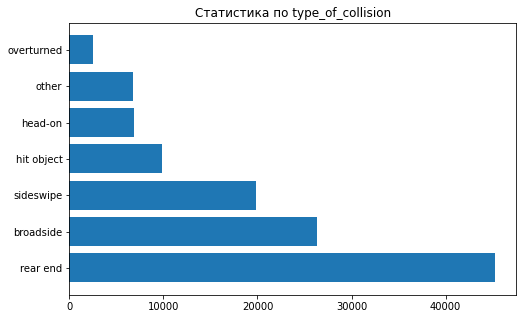

In [87]:
visualize_cat('type_of_collision')

Машины чаще бьются боковой или задней частью - к счастью, лобовые столкновения и опрокидывания случаются не так часто.

#### motor_vehicle_involved_with

In [88]:
df['motor_vehicle_involved_with'].unique() 

array(['fixed object', 'other motor vehicle', 'other object',
       'non-collision', 'bicycle', 'animal', 'parked motor vehicle',
       'motor vehicle on other roadway', None, 'train'], dtype=object)

In [89]:
cat_info('motor_vehicle_involved_with')

Количество пропусков: 332

Доля пропусков: 0.0028310494495655363 

other motor vehicle               93709
fixed object                       9153
other object                       5352
bicycle                            2787
non-collision                      2692
parked motor vehicle               2067
motor vehicle on other roadway      925
animal                              225
train                                29
Name: motor_vehicle_involved_with, dtype: int64


In [90]:
df[df['motor_vehicle_involved_with'].isna()].sample(10)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,intersection,weather,collision_damage,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
86415,5543911,2,0,had not been drinking,not under inflience,riverside,0.00,intersection,clear,middle damage,...,other,None,dry,normal,daylight,2012-02-21,17:39:00,sedan,auto,2.00
98060,5631863,2,0,had not been drinking,not under inflience,los angeles,"1,584.00",not intersection,clear,small damage,...,rear end,None,dry,normal,daylight,2012-04-20,12:50:00,sedan,auto,3.00
1875,5543748,1,1,had not been drinking,not under inflience,orange,450.00,not intersection,clear,small damage,...,sideswipe,None,dry,normal,daylight,2012-02-23,13:34:00,sedan,manual,4.00
59002,5449824,1,0,impairment unknown,not under inflience,ventura,100.00,not intersection,other,small damage,...,other,None,None,None,None,2012-01-03,10:30:00,sedan,manual,5.00
103929,5456609,1,1,had not been drinking,not under inflience,napa,50.00,not intersection,clear,middle damage,...,overturned,None,dry,normal,dark with street lights,2012-01-15,18:20:00,coupe,manual,8.00
79168,5403171,1,1,had not been drinking,not under inflience,san joaquin,331.00,not intersection,clear,fatal,...,overturned,None,dry,normal,daylight,2012-01-29,15:30:00,sedan,auto,4.00
75079,5509876,1,1,had not been drinking,not under inflience,san joaquin,"1,200.00",not intersection,clear,middle damage,...,other,None,dry,normal,dark with street lights,2012-02-15,18:15:00,coupe,manual,8.00
3386,5613277,1,1,impairment unknown,not under inflience,los angeles,0.00,intersection,raining,middle damage,...,sideswipe,None,wet,None,dark with street lights,2012-04-26,03:00:00,sedan,manual,3.00
24008,5631255,2,0,had not been drinking,not under inflience,kern,150.00,not intersection,clear,small damage,...,rear end,None,dry,normal,daylight,2012-05-25,16:06:00,sedan,auto,4.00
68575,5663680,1,0,had not been drinking,not under inflience,los angeles,0.00,unknown,clear,middle damage,...,other,None,dry,normal,daylight,2012-06-01,11:05:00,hatchback,auto,3.00


Судя по имеющимся пропускам, наиболее подходящим значением для большинства из них будет `other motor vehicle`.

In [91]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].fillna('other motor vehicle') 

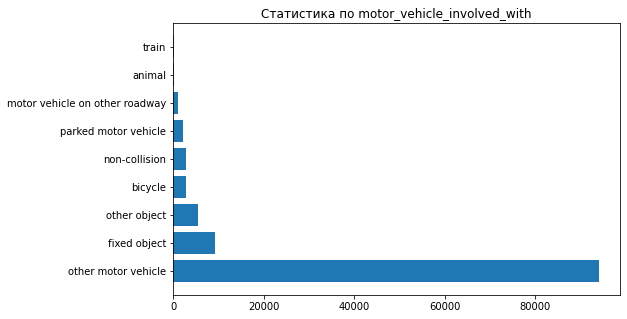

In [92]:
visualize_cat('motor_vehicle_involved_with')

По совместительству это и есть самое распространённое значение - машины чаще всего сталкиваются друг с другом, а не с недвижимыми объектами. 

#### road_surface

In [93]:
df['road_surface'].unique()

array(['dry', 'wet', 'snowy', None, 'slippery'], dtype=object)

In [94]:
cat_info('road_surface')

Количество пропусков: 761

Доля пропусков: 0.006489242864817389 

dry         105954
wet           9971
snowy          515
slippery        70
Name: road_surface, dtype: int64


In [95]:
df[df['road_surface'].isna()].sample(10)

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,intersection,weather,collision_damage,...,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
28068,5613161,2,0,had not been drinking,not under inflience,los angeles,52.00,not intersection,clear,small damage,...,rear end,other motor vehicle,None,normal,dark with street lights,2012-04-10,23:15:00,sedan,auto,4.00
44798,5506119,1,0,impairment unknown,under influence,los angeles,200.00,not intersection,clear,middle damage,...,other,non-collision,None,normal,dark with street lights,2012-01-13,17:45:00,coupe,manual,3.00
9779,5467483,1,1,impairment unknown,under influence,orange,"2,640.00",not intersection,clear,small damage,...,rear end,other motor vehicle,None,other,dark with no street lights,2012-01-13,17:44:00,sedan,auto,4.00
87180,5583200,2,0,had not been drinking,not under inflience,los angeles,15.00,not intersection,other,small damage,...,rear end,other motor vehicle,None,None,None,2012-03-10,17:00:00,sedan,manual,0.00
31076,5540674,2,0,had not been drinking,not under inflience,orange,193.00,not intersection,clear,middle damage,...,rear end,other motor vehicle,None,holes,daylight,2012-03-03,14:09:00,sedan,auto,2.00
62708,5610933,2,0,had not been drinking,not under inflience,los angeles,150.00,not intersection,clear,small damage,...,rear end,other motor vehicle,None,normal,daylight,2012-04-06,14:00:00,sedan,auto,11.00
11569,5545461,2,0,had not been drinking,not under inflience,los angeles,76.00,not intersection,clear,middle damage,...,rear end,other motor vehicle,None,normal,daylight,2012-02-26,10:30:00,sedan,auto,2.00
77962,5619032,1,1,had been drinking,not under inflience,alameda,285.00,not intersection,clear,middle damage,...,hit object,fixed object,None,holes,daylight,2012-05-12,16:26:00,coupe,manual,3.00
71279,5556784,2,0,had not been drinking,not under inflience,ventura,"3,696.00",not intersection,clear,small damage,...,rear end,other motor vehicle,None,construction,dark with no street lights,2012-03-19,20:06:00,sedan,manual,0.00
99468,5486323,1,1,impairment unknown,under influence,los angeles,500.00,not intersection,clear,small damage,...,broadside,parked motor vehicle,None,normal,daylight,2012-02-14,12:45:00,sedan,auto,4.00


В основном, у пропущенных значений хорошая погода, значит, можно предположить, что дорога будет сухая.

In [96]:
df['road_surface'] = df['road_surface'].fillna('dry')

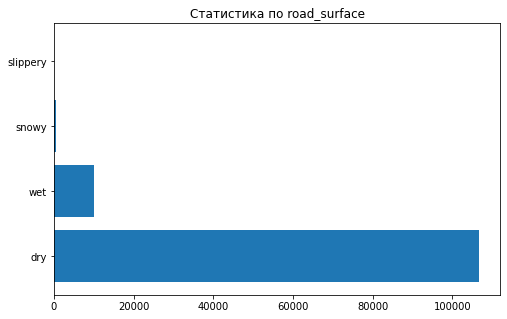

In [97]:
visualize_cat('road_surface')

Как и, собственно, в подавляющем большинстве случаев вообще.

#### road_condition

In [98]:
df = df.rename(columns={'road_condition_1': 'road_condition'})

In [99]:
df['road_condition'].unique()

array(['loose material', 'normal', 'obstruction', 'other', 'construction',
       None, 'holes', 'reduced width', 'flooded'], dtype=object)

In [100]:
cat_info('road_condition')

Количество пропусков: 568

Доля пропусков: 0.004843482190822966 

normal            112757
construction        2261
holes                469
obstruction          444
other                414
loose material       175
reduced width        127
flooded               56
Name: road_condition, dtype: int64


In [101]:
df['road_condition'] = df['road_condition'].fillna('other')

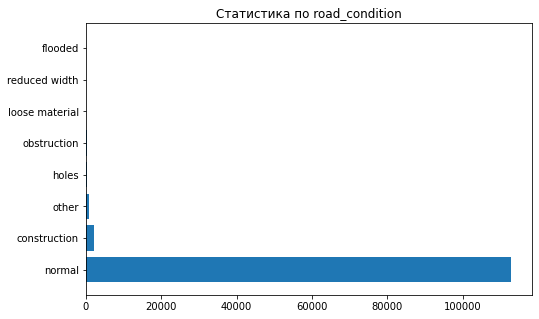

In [102]:
visualize_cat('road_condition')

Чтобы немного уменьшить сильный перевес, можно перевести признак в бинарный.

In [103]:
df['road_condition'] = df['road_condition'].where(df['road_condition'] == 'normal', other='not normal') 

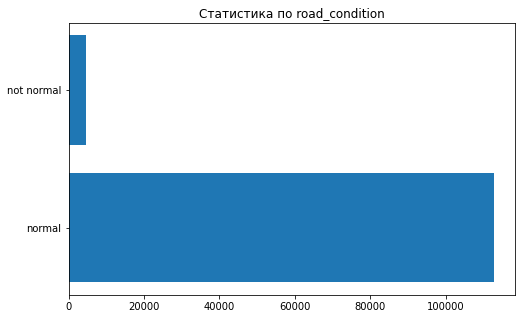

In [104]:
visualize_cat('road_condition')

#### lighting

In [105]:
df['lighting'].unique() 

array(['dark with street lights', 'daylight',
       'dark with no street lights', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

In [106]:
cat_info('lighting')

Количество пропусков: 329

Доля пропусков: 0.002805467677430908 

daylight                                   82183
dark with street lights                    22030
dark with no street lights                  8765
dusk or dawn                                3677
dark with street lights not functioning      287
Name: lighting, dtype: int64


Пропуски можно заменить самым распространённым значением, а две похожих категории объединить.

In [107]:
df['lighting'] = df['lighting'].replace({'dark with street lights not functioning': 'dark with no street lights'})
df['lighting'] = df['lighting'].fillna('daylight')

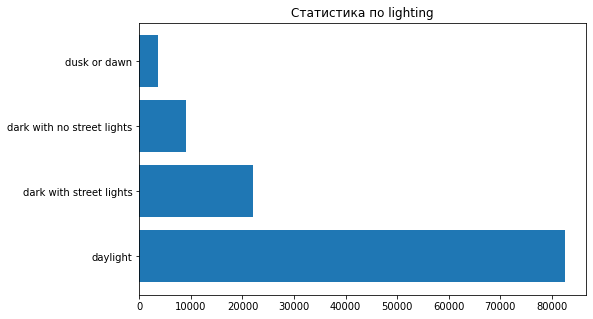

In [108]:
visualize_cat('lighting')

Редко такое бывает, что совсем нет освещения.

#### vehicle_type

In [109]:
df['vehicle_type'].unique()

array(['sedan', 'hatchback', 'coupe', 'minivan', 'other'], dtype=object)

In [110]:
cat_info('vehicle_type')

Количество пропусков: 0

Доля пропусков: 0.0 

sedan        76086
coupe        35412
hatchback     3282
minivan       2433
other           58
Name: vehicle_type, dtype: int64


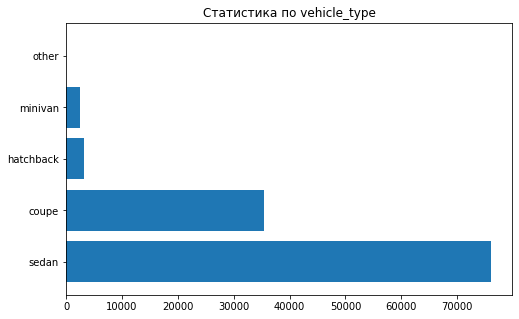

In [111]:
visualize_cat('vehicle_type')

Седанов наверное в принципе в автопарке больше всего.

#### vehicle_transmission

In [112]:
df['vehicle_transmission'].unique()

array(['manual', 'auto', None], dtype=object)

In [113]:
cat_info('vehicle_transmission')

Количество пропусков: 1857

Доля пропусков: 0.01583511695133494 

manual    60247
auto      55167
Name: vehicle_transmission, dtype: int64


Значений примерно одинаково, да и в принципе влияние КПП на аварийность сомнительно. Колонку можно удалить.

In [114]:
df = df.drop('vehicle_transmission', axis=1) 

#### collision_time

Дата происшествия вряд ли поможет в оценке аварийности маршрута, а вот время может быть полезно.

In [115]:
df = df.drop('collision_date', axis=1)

In [116]:
cat_info('collision_time')

Количество пропусков: 123

Доля пропусков: 0.001048852657519762 

15:00:00    926
15:30:00    799
16:00:00    738
18:00:00    718
15:20:00    673
           ... 
05:54:00      1
04:42:00      1
04:27:00      1
04:21:00      1
04:36:00      1
Name: collision_time, Length: 1436, dtype: int64


In [117]:
df = df[~df['collision_time'].isna()]

In [118]:
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour) 

In [119]:
cat_info('collision_time')

Количество пропусков: 0

Доля пропусков: 0.0 

15    10734
17     9498
16     8920
14     8883
18     8310
13     7724
12     7092
11     6032
7      5639
8      5560
19     5387
10     4852
20     4470
9      4325
21     3741
22     2879
23     2447
6      2231
2      1854
1      1751
0      1716
5      1310
3      1038
4       755
Name: collision_time, dtype: int64


In [120]:
def daytime(x):
    if 0 <= x <= 5:
        x = 'night'
    elif 6 <= x <= 11:
        x = 'morning'
    elif 12 <= x <= 17:
        x = 'day'
    elif 18 <= x <= 23:
        x = 'evening'
    return x 

In [121]:
df['collision_time'] = df['collision_time'].apply(daytime) 

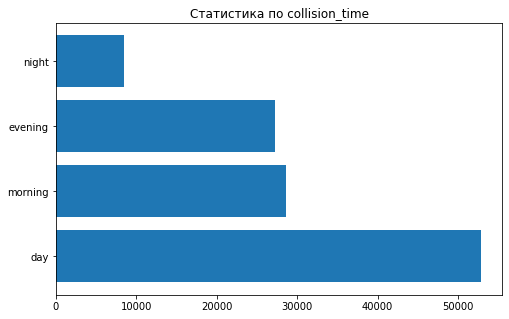

In [122]:
visualize_cat('collision_time')

Оказалось, что аварии чаще всего случаются в дневное время. Наверное, потому что поток машин наиболее плотный.

### Подготовка признаков к обучению

Посмотрим, что у нас осталось в итоговой таблице.

In [123]:
df.columns 

Index(['case_id', 'party_number', 'at_fault', 'party_sobriety',
       'party_drug_physical', 'county_location', 'distance', 'intersection',
       'weather', 'collision_damage', 'party_count', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition', 'lighting', 'collision_time', 'vehicle_type',
       'vehicle_age'],
      dtype='object')

In [124]:
df.head() 

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,county_location,distance,intersection,weather,collision_damage,party_count,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition,lighting,collision_time,vehicle_type,vehicle_age
0,5403037,1,1,had been drinking,under influence,san benito,0.00,intersection,clear,fatal,1,dui,hit object,fixed object,dry,not normal,dark with street lights,night,sedan,3.00
1,5454272,1,1,had not been drinking,not under inflience,orange,36.00,not intersection,raining,small damage,2,speeding,rear end,other motor vehicle,wet,normal,daylight,morning,sedan,0.00
2,5454272,2,0,had not been drinking,not under inflience,orange,36.00,not intersection,raining,small damage,2,speeding,rear end,other motor vehicle,wet,normal,daylight,morning,sedan,0.00
3,5455652,2,0,had not been drinking,not under inflience,solano,0.00,intersection,clear,middle damage,2,pedestrian violation,other,other object,dry,normal,dark with street lights,day,hatchback,11.00
4,5456212,1,1,had not been drinking,not under inflience,sacramento,300.00,not intersection,clear,small damage,2,speeding,rear end,other motor vehicle,dry,normal,daylight,day,sedan,3.00


In [125]:
df.duplicated().sum() 

3386

In [126]:
df = df.drop_duplicates() 

In [127]:
features = df.drop(columns=['case_id', 'party_number', 'at_fault'])
target = df['at_fault']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True) 

In [129]:
print(X_train.shape)
print(y_train.shape) 
print(X_test.shape)
print(y_test.shape) 

(91009, 17)
(91009,)
(22753, 17)
(22753,)


In [130]:
numeric = list(features.select_dtypes(exclude=['object']).columns) 
categorical = list(features.select_dtypes(include=['object']).columns)
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

X_train_ohe = col_transformer.fit_transform(X_train)
X_test_ohe = col_transformer.transform(X_test)

## Лучшая модель

Для оценки качества моделей будем использовать метрику AUC, т.к. нам важно оценить предсказания вероятностей классов.

### CatBoost

In [131]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) 

In [132]:
# базовая модель catboost
catb = CatBoostClassifier(random_state=42, 
                         cat_features=categorical, 
                         iterations=100,
                         early_stopping_rounds=10,
                         learning_rate=0.1)

In [133]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [134]:
%%time
params_catb = {
    'depth': [14, 15, 16]
}

grid_catb = GridSearchCV(catb, param_grid=params_catb, cv=kf,
                        scoring='roc_auc').fit(X_train, y_train, verbose=False) 

CPU times: total: 1h 8min 22s
Wall time: 15min 27s


In [135]:
results = grid_catb.cv_results_
best_index = grid_catb.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
AUC = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest AUC: {AUC}") 

Fit time: 59.76615282694498
Predict time: 0.10798045794169109
Best AUC: 0.7625747960708195


In [136]:
grid_catb.best_params_

{'depth': 14}

### Нейросеть

In [137]:
class EarlyStopping_1():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True 

In [138]:
# гиперпараметры нейросети
num_epochs = 200
batch_size = 1000
#accumulation_iteration = 5
#num_batches = ceil(len(X_train_ohe)/batch_size)
loss = nn.BCELoss() 
learning_rate = 0.01
early_stopping = EarlyStopping_1() 

In [139]:
X_train_tensor = torch.from_numpy(X_train_ohe).float()
X_test_tensor = torch.from_numpy(X_test_ohe).float()

y_train_tensor = torch.from_numpy(np.array(y_train)).float() 
y_test_tensor = torch.from_numpy(np.array(y_test)).float() 

dataset_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) 
dataset_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)  


train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0) 

In [140]:
class Basic_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Basic_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x) 
        x = self.layer2(x)
        x = torch.tanh(x) 
        x = self.layer3(x)
        x = torch.sigmoid(x)
        
        return x

In [141]:
# инициализация весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)

In [142]:
n_in_neurons = X_train_tensor.size(dim=1)
n_out_neurons = 1
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 10

In [143]:
basic_net = Basic_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
basic_net.apply(init_weights)
optimizer = torch.optim.Adam(basic_net.parameters(), lr=learning_rate)

In [144]:
skorch_classifier = NeuralNetClassifier(module=basic_net, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=learning_rate,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.BCELoss,
                                      callbacks=[
                ('auc', EpochScoring(scoring='roc_auc', lower_is_better=False)),
                ('estoper', EarlyStopping(lower_is_better=False, monitor='roc_auc')),
            ],
                                     ) 

In [145]:
params = {
    'module__n_in_neurons': [n_in_neurons],
    'module__n_hidden_neurons_1': range(10, 30, 5),
    'module__n_hidden_neurons_2': range(10, 30, 5),
    'module__n_out_neurons': [n_out_neurons],
    #'lr': [1e-3, 1e-4]
}

In [146]:
grid = RandomizedSearchCV(skorch_classifier, params, cv=3, scoring="roc_auc", verbose=3) 
grid.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.7392        0.6110       0.6761        0.5820  0.9124
      2     0.7492        0.5702       0.6794        0.5640  1.0003
      3     0.7534        0.5567       0.6811        0.5531  1.0220
      4     0.7569        0.5482       0.6843        0.5467  0.7958
      5     0.7598        0.5432       0.6855        0.5420  0.9329
      6     0.7622        0.5393       0.6860        0.5383  0.8494
      7     0.7637        0.5359       0.6858        0.5357  0.7709
      8     0.7645        0.5333       0.6855        0.5341  0.8191
      9     0.7648        0.5314       0.6867        0.5332  0.8500
     10     0.7646        0.5300       0.6874        0.5329  0.8437
     11     0.7644        0.5288       0.6868        0.5328  0.8562
     12     0.7642        0.5279       0.6862        0.

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=Basic_Net(
    (layer1): Linear(in_features=125, out_features=20, bias=True)
    (layer2): Linear(in_features=20, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=1, bias=True)
  ),
),
                   param_distributions={'module__n_hidden_neurons_1': range(10, 30, 5),
                                        'module__n_hidden_neurons_2': range(10, 30, 5),
                                        'module__n_in_neurons': [125],
                                        'module__n_out_neurons': [1]},
                   scoring='roc_auc', verbose=3)

In [147]:
grid.best_params_ 

{'module__n_out_neurons': 1,
 'module__n_in_neurons': 125,
 'module__n_hidden_neurons_2': 10,
 'module__n_hidden_neurons_1': 20}

In [148]:
grid.best_score_

0.7664172677889862

In [151]:
basic_net = Basic_Net(n_in_neurons, 10, 20, n_out_neurons)
basic_net.apply(init_weights)
optimizer = torch.optim.Adam(basic_net.parameters(), lr=learning_rate) 
num_epochs = 200 

In [152]:
for epoch in range(num_epochs):
    basic_net.train() 
    for batch in train_dataloader:
        data_train, target_train = batch   # просто выгружаем данные 
        optimizer.zero_grad() 
        preds = basic_net.forward(data_train).flatten()
        loss_value = loss(preds, target_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 10 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            basic_net.eval()
            for batch in test_dataloader:
                data_test, target_test = batch # просто выгружаем данные

                test_preds = basic_net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                BCE_loss = loss(test_preds, target_test) 

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        AUC = roc_auc_score(y_test, predicted_temp)
        early_stopping(AUC)
        print(f"epoch:{epoch}, AUC test: {AUC}")

        if early_stopping.early_stop:
            print('Early Stopping!!!')
            break 

INFO: Early stopping counter 6 of 5
INFO: Early stopping
epoch:0, AUC test: 0.7573175315171947
Early Stopping!!!
